# DeepHubble

Here, we are exploring the Pro-GAN as describes in [this paper](https://arxiv.org/pdf/1710.10196.pdf)

In [1]:
import os
import random
import sys
import time
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as torchv
import torchx
from matplotlib import gridspec
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from PIL import Image

In [2]:
module_path = os.path.abspath(os.path.join("Pro-GAN"))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import Dataset
from networks import Generator, Discriminator
from train import FromTensor, generate_noise, generate_fake_images

## Data

The ground truth data will be sampled from the Hubble eXtreme Deep Field (XDF). As seen below

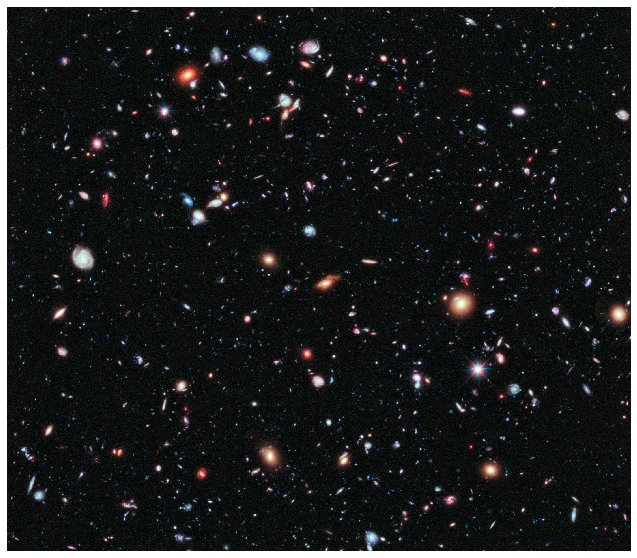

In [3]:
HubbleXDF = Image.open("../data/HubbleXDF_cropped.jpg")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(HubbleXDF)
plt.axis('off')
plt.show()

We will be sampling images from the deep field image for our model to learn the distribution for. For the purpose of progressively growing our GAN, we sample $512 \times 512$ images from the XDF and then scale it down to $4\times4$ and then scaling back up as we train. For example:

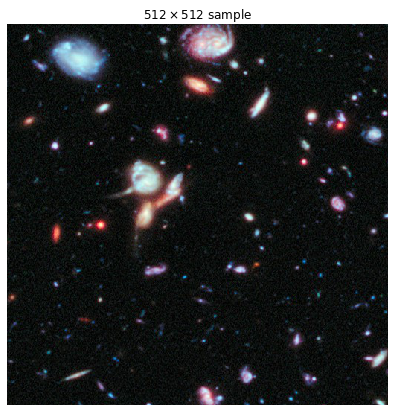

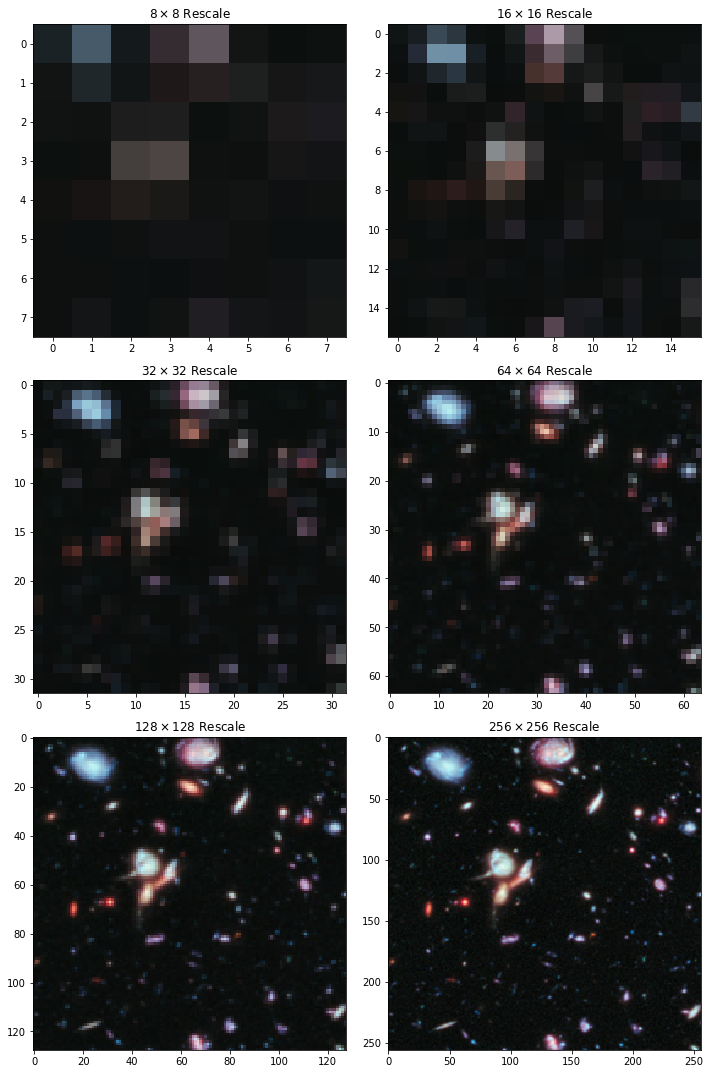

In [4]:
def sample_image(width, height):
    random.seed(20120925)  # Date the XDF was captured: September 25th, 2012
    return torchv.transforms.Compose([
        torchv.transforms.RandomCrop((512, 512)),
        torchv.transforms.Resize((width, height)),
    ])(HubbleXDF)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(sample_image(512, 512))
plt.axis("off")
plt.title(r"$512 \times 512$ sample")
plt.show()

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
fig.tight_layout()
ax[0][0].imshow(sample_image(8, 8))
ax[0][0].set_title(r"$8 \times 8$ Rescale")
ax[0][1].imshow(sample_image(16, 16))
ax[0][1].set_title(r"$16 \times 16$ Rescale")
ax[1][0].imshow(sample_image(32, 32))
ax[1][0].set_title(r"$32 \times 32$ Rescale")
ax[1][1].imshow(sample_image(64, 64))
ax[1][1].set_title(r"$64 \times 64$ Rescale")
ax[2][0].imshow(sample_image(128, 128))
ax[2][0].set_title(r"$128 \times 128$ Rescale")
ax[2][1].imshow(sample_image(256, 256))
ax[2][1].set_title(r"$256 \times 256$ Rescale")
plt.show()

## Training Times

| Resolution | Total Images shown | Minibatch Size | Time Spent Training |
|------------|--------------------|----------------|---------------------|
| 4x4        | 800,000            | 64             | 670 seconds         |
| 8x8        | 1,600,000          | 64             | 2216 seconds        |
| 16x16      | 1,600,000          | 64             | 4505 seconds        |
| 32x32      | 1,600,000          | 64             | 9442 seconds        |
| 64x64      | 1,600,000          | 64             | 17980 seconds       |
| 128x128    | 1,600,000          | 64             | 28649 seconds       |
| 256x256    | 1,600,000          | 32             | 93622 seconds       |

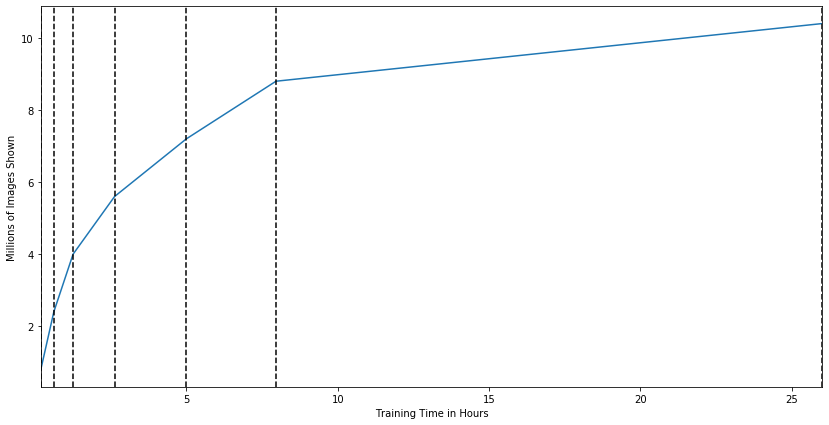

In [5]:
training_times = pd.DataFrame({
    "Resolution": [f"{2**res}x{2**res}" for res in range(2, 9)],
    "Training Time (s)": [670, 2216, 4505, 9442, 17980, 28649, 93622],
    "Images Shown": [1600000 if res > 2 else 800000 for res in range(2, 9)]
})
training_times["Images Shown"] = training_times["Images Shown"].cumsum()
training_times["Millions of Images Shown"] = training_times["Images Shown"] / 1000000
training_times["Training Time (hr)"] = training_times["Training Time (s)"] / 3600

training_times.plot(x="Training Time (hr)", y="Millions of Images Shown", legend=None, figsize=(14, 7))
plt.xlabel("Training Time in Hours")
plt.ylabel("Millions of Images Shown")

for res, xc in map(tuple, training_times[["Resolution", "Training Time (hr)"]].values):
    plt.axvline(x=xc, color='k', linestyle='--')
    
plt.show()

It is clear that we get a huge performance boost by training the model in stages and progressively growing it between stages

## Generating Images

After training, we can use the generator to generate images and see what the generator has learnt

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 256x256

In [7]:
generator = Generator(resolution=256, device=device)
generator.load("../data/checkpoints/final_pro-gan_generator_256x256.pt")

discriminator = Discriminator(resolution=256, device=device)
discriminator.load("../data/checkpoints/final_pro-gan_discriminator_256x256.pt")

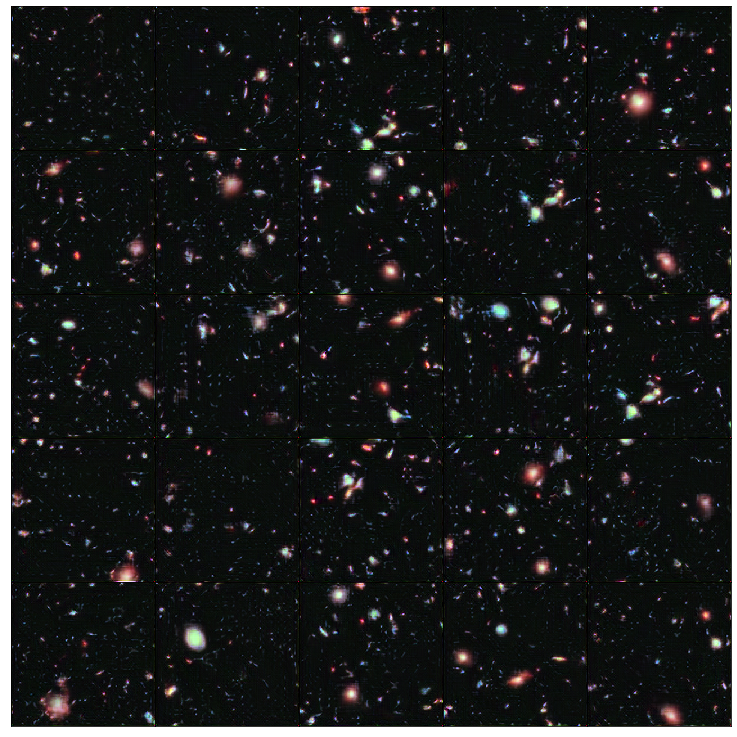

In [8]:
with torch.no_grad():
    generator.eval()
    discriminator.eval()
    
    nrow = 5
    ncol = 5
    
    noise = generate_noise(generator, minibatch_size=nrow * ncol)
    fake_output = generator.forward(noise, alpha=1)
    fake_images = FromTensor(fake_output)

    fig = plt.figure(figsize=(12, 12))    
    
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.0, hspace=0.0, 
             top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
    
    for i, (r, c) in enumerate(np.ndindex((nrow, ncol))):
        ax = plt.subplot(gs[r, c])
        ax.imshow(fake_images[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
#     plt.savefig("../images/generator_trained_256x256_other.png", bbox_inches='tight', pad_inches = 0)
    plt.show()